In [1]:
%%capture
!pip install numpy matplotlib torchvision torch sklearn

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import sys
import os
from torch.utils.data import DataLoader, Dataset
from dataset import AlphaTauDataset, TestAlphaTauDataset

# Loading Data

In [35]:
train_dataset = AlphaTauDataset('projects/def-sponsor00/data/train/')
valid_dataset = AlphaTauDataset('projects/def-sponsor00/data/validation/')
test_dataset = TestAlphaTauDataset('projects/def-sponsor00/data/test/')

In [4]:
len(train_dataset)

397

In [5]:
len(valid_dataset)

103

# UNet Model

We use a pre-trained UNET from PyTorch hub.

In [12]:
import torch
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=3, out_channels=1, init_features=32, pretrained=True)
model = model.cuda()
# model.load_state_dict(torch.load('scratch/model.ckpt'))

Using cache found in /home/user022/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


We use DiceLoss for CT image seed segmentation as suggested in the literature for semantic segmentation of small objects.

In [13]:
# taken from https://www.kaggle.com/bigironsphere/loss-function-library-keras-pytorch
import torch.nn as nn
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets): 
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection+1)/(inputs.sum() + targets.sum() + 1)  
        
        return 1 - dice

In [14]:
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=1)
opt = torch.optim.Adam(model.parameters(), lr=1e-5)

# Data Visualization

(array([5.8917e+05, 6.1900e+02, 1.1000e+01, 3.0000e+00, 4.0000e+00,
        5.0000e+00, 3.0000e+00, 1.0000e+00, 4.0000e+00, 4.0000e+00]),
 array([-0.6197349,  4.0912337,  8.802202 , 13.513171 , 18.22414  ,
        22.935108 , 27.646078 , 32.357044 , 37.068016 , 41.778984 ,
        46.489952 ], dtype=float32),
 <BarContainer object of 10 artists>)

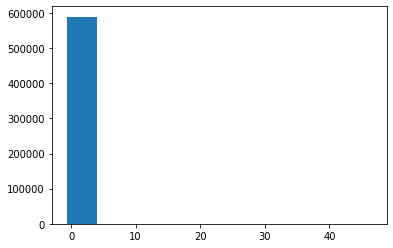

In [15]:
plt.hist(train_dataset[3][0][8].reshape(-1).detach().cpu().numpy())

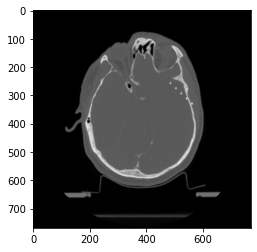

In [16]:
plt.imshow(train_dataset[3][0][12], cmap='gray')

In [10]:
# torch.save(model.state_dict(), 'scratch/best_model_3.ckpt')

In [ ]:
for epoch in range(200):
    print('epoch %d' % epoch)
    losses = []
    for batch in train_dataloader:
        model.train()
        imgs, masks, seeds = batch
        print(imgs.shape)
        imgs = imgs.cuda()
        masks = masks.cuda()
        for index in range(0, 41):
            opt.zero_grad()
            img_slice = imgs[:, index+1:index+4]
            mask_slice = masks[:, index]
            logits = model(img_slice)
            loss = DiceLoss()(logits,mask_slice)
            loss.backward()
            opt.step()
            losses.append(loss.item())
        print('mean loss', sum(losses)/len(losses))
        torch.save(model.state_dict(), 'scratch/model.ckpt')

In [17]:
model.load_state_dict(torch.load('/best_model_2.ckpt'))

<All keys matched successfully>

# Monitoring Validation

In [82]:
vali = 33
with torch.no_grad():
    model.eval()
    imgs, masks, seed = valid_dataset[vali]
    logits = []
    losses = []
    imgs = imgs.cuda().unsqueeze(0)
    masks = masks.cuda().unsqueeze(0)
    for index in range(0, 41):
        img_slice = imgs[:, index+1:index+4]
        mask_slice = masks[:, index]
        logit = model(img_slice)
        loss = DiceLoss()(logit,mask_slice)
        logits.append(logit.squeeze())
        losses.append(loss.item())
    print('mean loss', sum(losses)/len(losses))

mean loss 0.19400525383832978


In [83]:
logits = torch.stack(logits, axis=0)

## Validation performance of seed semantic segmentation

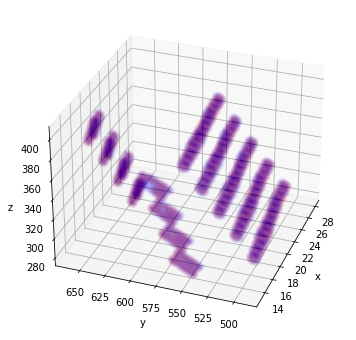

In [85]:
points_generated = np.concatenate(list(zip(np.where(logits.detach().cpu().numpy() > 0.5))), axis=0).T
points = np.concatenate(list(zip(np.where(masks[0].detach().cpu().numpy() > 0))), axis=0).T
p = points
p_g = points_generated
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')                
img = ax.scatter(p[:,0], p[:,1], p[:,2],c='blue', alpha=0.01)
img = ax.scatter(p_g[:,0], p_g[:,1], p_g[:,2],c='red',alpha=0.01)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.view_init(30, 200)
# fig.colorbar(img)
plt.savefig('val'+str(vali)+'.png')

# Seed Counting

In [14]:
import numpy as np
from sklearn.mixture import BayesianGaussianMixture
X = np.concatenate(list(zip(np.where(logits.detach().cpu().numpy() > 0.5))), axis=0).T
bgm = BayesianGaussianMixture(n_components=30, random_state=43, max_iter=1000).fit(X)
used_components = list(set(bgm.predict(X).tolist()))
used_components

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 14, 15, 16, 17, 18, 20, 23, 24, 25, 29]

In [15]:
from collections import Counter
effective_components = []
for component, count in Counter(bgm.predict(X).tolist()).items():
    if count > (X.shape[0]/(len(used_components)*2)):
        effective_components.append(component)
        print(component, count, 'OK')
    else:
        print(component, count)

13 76
8 92
15 457 OK
16 29
14 25
24 3
20 11
4 1850 OK
9 1666 OK
0 1737 OK
7 1663 OK
5 1326 OK
6 1349 OK
29 1566 OK
25 34
1 977 OK
17 537 OK
18 2
2 320
10 332 OK
23 50
3 82


In [16]:
bgm.means_[effective_components].shape

(11, 3)

In [17]:
xyz = bgm.means_[effective_components]
#eEigen Decomposition of the Covariance Matrix
w, v = np.linalg.eig(bgm.covariances_[effective_components])
i = np.arange(len(v))
dxyz = v[i,:, np.argmax(w,1)]
out = np.concatenate((xyz,dxyz),1)

We use number of effective components in the bayesian gaussian which is fit to the seed pixels as an estimation for the number of seeds

In [18]:
out.shape

(11, 6)

# Test Dataset Seed Segmentation

7
5
10
14


KeyboardInterrupt: 

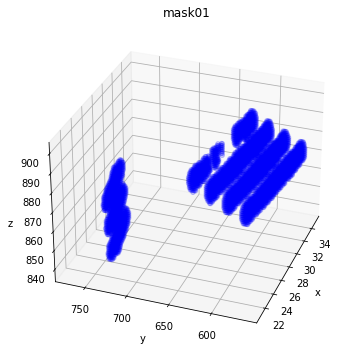

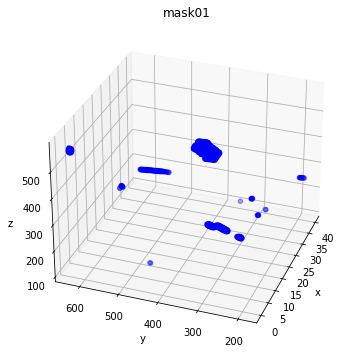

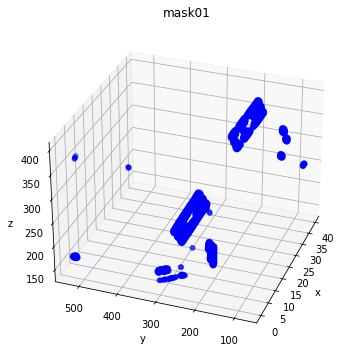

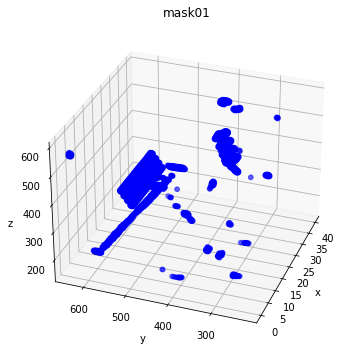

In [36]:
for i in range(len(test_dataset)):
    with torch.no_grad():
        model.eval()
        imgs = test_dataset[i]
        logits = []
        imgs = imgs.cuda().unsqueeze(0)
        for index in range(0, 41):
            img_slice = imgs[:, index+1:index+4]
            logit = model(img_slice)
            logits.append(logit.squeeze())

        logits = torch.stack(logits, axis=0)
        
        points_generated = np.concatenate(list(zip(np.where(logits.detach().cpu().numpy() > 0.5))), axis=0).T
        p_g = points_generated
        fig = plt.figure(figsize=(8,6))
        ax = fig.add_subplot(111, projection='3d')                
        img = ax.scatter(p_g[:,0], p_g[:,1], p_g[:,2],c='blue',alpha=0.2)
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("z")
        ax.set_title("mask01")
        ax.view_init(30, 200)
        if not os.path.exists('test/'+str(i)+'/'):
            os.mkdir('test/'+str(i)+'/')
        plt.savefig('test/'+str(i)+'/'+str(i)+'.png')

        import numpy as np
        from sklearn.mixture import BayesianGaussianMixture
        X = np.concatenate(list(zip(np.where(logits.detach().cpu().numpy() > 0.5))), axis=0).T
        bgm = BayesianGaussianMixture(n_components=30, random_state=43, max_iter=1000).fit(X)
        used_components = list(set(bgm.predict(X).tolist()))

        from collections import Counter
        effective_components = []
        for component, count in Counter(bgm.predict(X).tolist()).items():
            if count > (X.shape[0]/(len(used_components)*2)):
                effective_components.append(component)

        xyz = bgm.means_[effective_components]
        #eEigen Decomposition of the Covariance Matrix
        w, v = np.linalg.eig(bgm.covariances_[effective_components])
        index = np.arange(len(v))
        dxyz = v[index,:, np.argmax(w,1)]
        out = np.concatenate((xyz,dxyz),1)
        np.save('test/'+str(i)+'/'+str(i)+'.npy', out)
        print(out.shape[0])